In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from bcnf.simulation.physics import get_data
from bcnf.model.cnf import CondRealNVP
from bcnf.train.train import train_CondRealNVP
from bcnf.utils import partconv1d, get_gaussian_kernel

In [3]:
x0_pdf = lambda size: np.random.uniform(-10, 10, size=size)
v0_pdf = lambda size: np.random.uniform(-10, 10, size=size)
g_pdf = lambda size: np.random.normal(9.81, 0.1, size=size) * np.array([0, 0, -1])
w_pdf = lambda size: np.random.normal(0, 1, size=size) * np.array([1, 1, 0.1])
b_pdf = lambda size: np.random.uniform(0, 1, size=size)
m_pdf = lambda size: np.random.uniform(0.5, 1.5, size=size)
a_pdf = lambda size: np.random.uniform(0, 0, size=size)

In [4]:
X, y = get_data(
    x0_pdf=x0_pdf,
    v0_pdf=v0_pdf,
    g_pdf=g_pdf,
    w_pdf=w_pdf,
    b_pdf=b_pdf,
    m_pdf=m_pdf,
    a_pdf=a_pdf,
    T=5.0,
    dt=0.1,
    N=10_000,
    break_on_impact=False
)

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2024_03_25)

print(f'{X_train.shape=}')
print(f'{X_val.shape=}')
print(f'{y_train.shape=}')
print(f'{y_val.shape=}')


  5%|▌         | 514/10000 [00:00<00:13, 703.17it/s]

In [ ]:
X_train.shape

(8000, 50, 3)

In [ ]:
feature_network = torch.nn.Sequential(
    nn.Linear(X_train.shape[1] * X_train.shape[2], 1024),
    nn.GELU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 1024),
    nn.GELU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 1024),
    nn.GELU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 1024),
    nn.GELU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 1024),
).to(device)  # Output dimension seems to be important

In [ ]:
cnf = CondRealNVP(
    input_size=y_train.shape[1],
    hidden_size=64,
    n_blocks=32,
    n_conditions=feature_network[-1].out_features,
    feature_network=feature_network,
    dropout=0.0).to(device)

optimizer = torch.optim.Adam(cnf.parameters(), lr=1e-4)

In [ ]:
X_train_tensor = torch.tensor(X_train.reshape(X_train.shape[0], -1), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val.reshape(X_val.shape[0], -1), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

print(f'{X_train_tensor.shape=}')
print(f'{y_train_tensor.shape=}')
print(f'{X_val_tensor.shape=}')
print(f'{y_val_tensor.shape=}')

X_train_tensor.shape=torch.Size([8000, 150])
y_train_tensor.shape=torch.Size([8000, 17])
X_val_tensor.shape=torch.Size([2000, 150])
y_val_tensor.shape=torch.Size([2000, 17])


In [ ]:
loss_history = train_CondRealNVP(
    model=cnf,
    optimizer=optimizer,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    n_epochs=3000,
    batch_size=512);

Train: -23.3972 - Val: -27.2593: 100%|██████████| 2000/2000 [10:11<00:00,  3.27it/s]


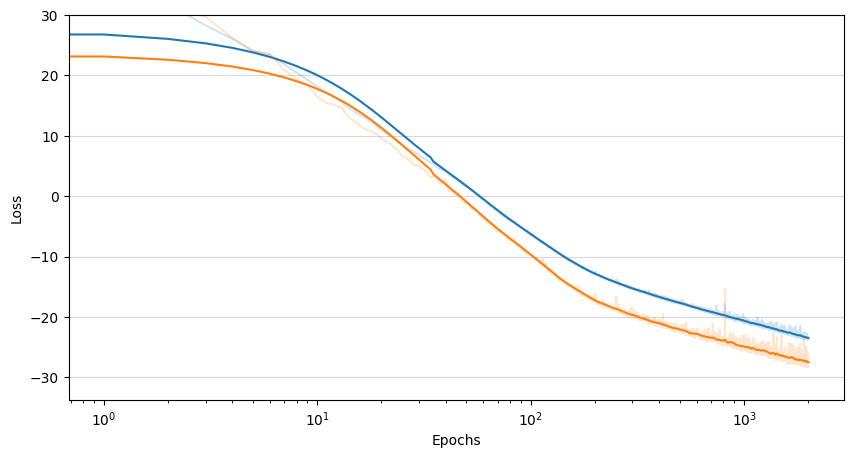

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(loss_history['train'], alpha=0.2, color='C0')
ax.plot(partconv1d(np.array(loss_history['train']), kernel=get_gaussian_kernel(sigma=10)), label='train', color='C0')

ax.plot(loss_history['val'], alpha=0.2, color='C1')
ax.plot(partconv1d(np.array(loss_history['val']), kernel=get_gaussian_kernel(sigma=10)), label='val', color='C1')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

ax.set_xscale('log')
ax.set_ylim(None, 30)
ax.grid(axis='y', alpha=0.5)

In [ ]:
cnf.eval();

In [ ]:
N_SAMPLES = 10000

In [ ]:
y_hat = cnf.sample(n_samples=N_SAMPLES, y=X_val_tensor[0])
y_hat = y_hat.cpu().detach().numpy()
y_hat.shape

y.shape=torch.Size([150])


(10000, 17)

In [ ]:
y_prior = np.column_stack([
    x0_pdf(size=(N_SAMPLES, 3)),
    v0_pdf(size=(N_SAMPLES, 3)),
    g_pdf(size=(N_SAMPLES, 3)),
    w_pdf(size=(N_SAMPLES, 3)),
    b_pdf(size=(N_SAMPLES,)),
    m_pdf(size=(N_SAMPLES,)),
    a_pdf(size=(N_SAMPLES, 3))
])

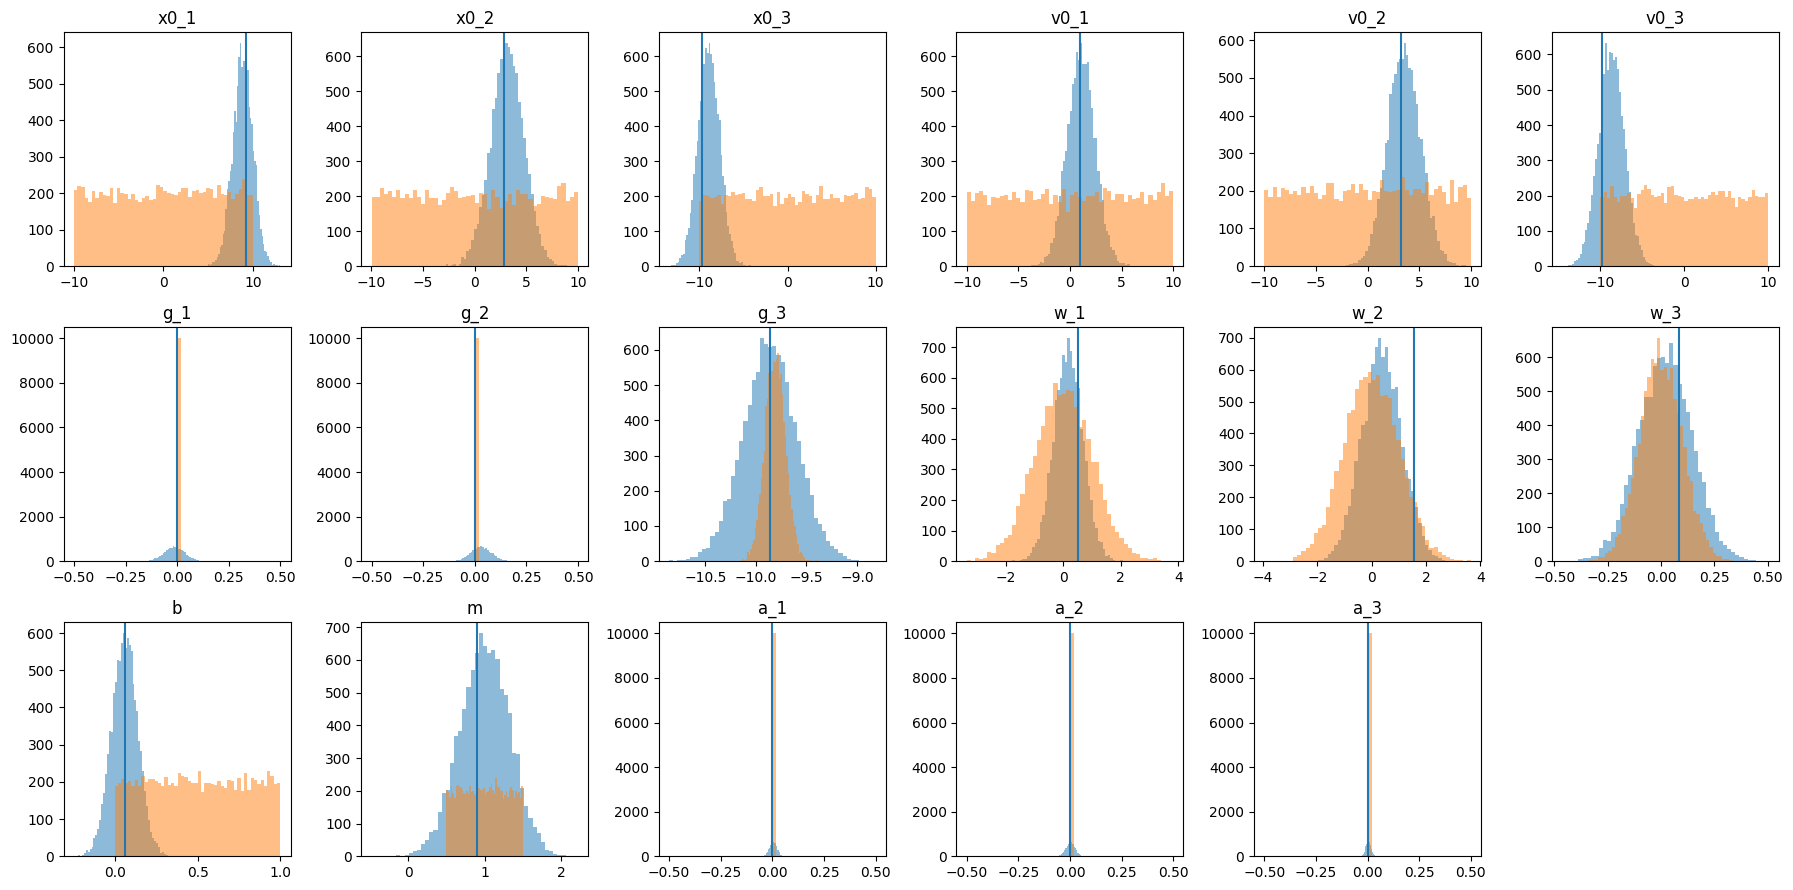

In [ ]:
COLS = 6
ROWS = np.ceil(y_hat.shape[1] / COLS).astype(int)

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 3))

for i, name in zip(range(y_hat.shape[1]), ['x0_1', 'x0_2', 'x0_3', 'v0_1', 'v0_2', 'v0_3', 'g_1', 'g_2', 'g_3', 'w_1', 'w_2', 'w_3', 'b', 'm', 'a_1', 'a_2', 'a_3']):
    ax.flatten()[i].axvline(y_val_tensor[0, i].cpu().detach().numpy(), color='C0')
    ax.flatten()[i].hist(y_hat[:, i], bins=50, alpha=0.5, color='C0')
    ax.flatten()[i].set_title(name)

    # Show the prior
    ax.flatten()[i].hist(y_prior[:, i], bins=50, alpha=0.5, color='C1')

for i in range(y_hat.shape[1], COLS * ROWS):
    ax.flatten()[i].axis('off')

fig.tight_layout()